# BERT Weather Condition Custom Training and Sentiment Analysis Evaluation

Import the necessary libraries and packages. Pandas for the dataframe and in-memory data management. Numpy for linear algebra, wordcloud and matplotlib for visualization.

## Download Models and Import Libraries

In [1]:
!pip install simpletransformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 KB 4.1 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 26.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 25.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 43.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 24.8 MB/s eta 0:00:00:00:01
  Using cached tensorboard-2.8.0-py3-none-any.whl (5.8 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 22.5 MB/s eta 0:00:00:00:0100:01
  Using cached requests-2.27.1-py2.py3-none-any.whl (63 kB)
  Using cached scipy-1.8.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (41.6 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 25.6 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.

In [ ]:
!pip install transformers

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import os
import time
import logging

## Data Loading

Logging processes, print a loading bar to track progress in data refactoring processes.

In [4]:
# Print iterations progress
def printProgressBar(iteration, total, prefix='', suffix='Completed', decimals=1, length=100, fill='█', printEnd="\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end=printEnd)
    # Print New Line on Complete
    if iteration == total:
        print('\r')

Import and read the raw data into a pandas dataframe

In [5]:
#path = "/Users/Kamran/Documents/GitHub/bert-model-eval/SentimentTrainingEval/daily_weather_2020.csv"
path = "daily_weather_2020.csv" # path to data csv
if(os.path.exists(path)):
    print("File Found")
    df = pd.read_csv(path, usecols=['summary', 'icon'], low_memory=True, dtype=str, encoding="utf-8")
else:
    print("no file found")

File Found


Import the cleaned dataset into a pandas dataframe. The cleaned dataset is already normalized, labels with integers, and split.

This cell should only be run if the cleaned dataset is being used in lieu of the regular dataset.

Loading a pre-cleaned dataset saves memory and runtime resources.

In [6]:
path= "daily_weather_2020_cleaned.csv"

if(os.path.exists(path)):
  print("File Found")
  df = pd.read_csv(path, usecols=['text', 'labels'], low_memory=True, dtype=str, encoding="utf-8")

df.head()

,summary,icon
0,Rain (with a chance of 1–3 in. of snow) until ...,rain
1,Light rain throughout the day.,rain
2,Clear throughout the day.,rain
3,Partly cloudy throughout the day.,partly-cloudy-day
4,Light rain throughout the day.,rain


# Data Preprocessing

Replace the icon column of the dataframe and check all the data was loaded properly as expected. The icon column items are replaced with the proper sentiment instead of the current icon value. This will help with validation when training the data. The entire dataset has validation.

In [7]:
# Print the dataframe basic information
df = df.rename(columns={'summary':'text', 'icon': 'labels'})
df.info()
# Set up the validation column in the dataframe without modifying the raw data
def setValidation():
    for i in range(len(df.labels)):
        printProgressBar(i, len(df.labels), prefix='SETTING UP DATA VALIDATION')
        val = df.labels[i]
        if val == 'rain' or val == 'snow' or val == 'wind' or val == 'fog':
            df.labels[i] = 'negative' # negative sentiment
        elif val == 'clear-day':
            df.labels[i] = 'positive' # positive sentiment
        elif val == 'partly-cloudy-day' or val == 'cloudy':
            df.labels[i] = 'neutral' # neutral (possibly not enough data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30688 entries, 0 to 30687
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    30685 non-null  object
 1   labels  30688 non-null  object
dtypes: object(2)
memory usage: 479.6+ KB


The validation that is setup can be tested by running the snippet below. This is a time consuming and resource intensive step, so it is not recommended to run this when reusing the same dataset.

In [8]:
# check the validation edit worked
def checkValidationSetting():
    print("CHECKING VALIDATION DATA")
    positive_count = 0
    negative_count = 0
    neutral_count = 0

    for i in range(len(df.labels)):
        printProgressBar(i, len(df.labels), prefix='CHECKING REFACTORED DATA')
        if(df.labels[i] == 'positive'):
            positive_count +=1
        elif(df.labels[i] == 'negative'):
            negative_count +=1
        elif(df.labels[i] == 'neutral'):
            neutral_count +=1

    print('positive Count: ' + str(positive_count))
    print('Unfavorable Count: ' + str(negative_count))
    print('Neutral Count: ' + str(neutral_count))


start = time.time()
setValidation()
df['labels'].value_counts()
print('==PROCESS COMPLETED==\n', time.time()-start, 'seconds')


SETTING UP DATA VALIDATION |████████████████████████████████████████████████----------------------------------------------------| 48.3% Completed

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



SETTING UP DATA VALIDATION |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.9% Completed

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Normalize the data for equal numbers of each label.

In [9]:
# Equalize the number of labels
def equalizeData(df):
    neutral, positive, negative = [], [], []
    for i in range(len(df.labels)):
        printProgressBar(i, len(df), prefix='Normalizing Data')
        if df.labels[i] == 'neutral':
            neutral.append(df.iloc[i])
        elif df.labels[i] == 'positive':
            positive.append(df.iloc[i])
        elif df.labels[i] == 'negative':
            negative.append(df.iloc[i])
    return pd.DataFrame(columns=['text', 'labels'], data=neutral[:8527] + positive[:8527] + negative[:8527])

df = equalizeData(df)

Normalizing Data |█████████████████████████████████████████████████---------------------------------------------------| 49.5% Completed

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Force Wrap Data Types

In [10]:
df['labels'] = df['labels'].astype(str)

## Data Visualization
The input data is visualized here to validate the efficacy of the dataset and the expected parameters. Wordcloud visualization was thought to not be an efficient visualization because specific words do not matter, we are testing for overall sentiment using a variety of key words, some will not appear in real world data. 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25581 entries, 3 to 20037
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    25578 non-null  object
 1   labels  25581 non-null  object
dtypes: object(2)
memory usage: 599.6+ KB


/home/kamran/Documents/bert-model-eval/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


neutral     8527
positive    8527
negative    8527
Name: labels, dtype: int64

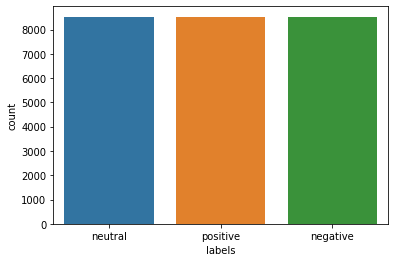

In [11]:
df.describe()
df.info()

sns.countplot(df.labels)

df['labels'].value_counts()

Normalize the data

## Test and Train DataFrames

In [12]:
train,eval = train_test_split(df.astype(str),test_size=0.1)

## Prepare Labels for Tensors
The default model outputs are overwritten here and replaced with the relevant condition sentiment

In [13]:
# 0,1,2 : positive,negative,neutral
def making_label(st):
    if(st=='positive'):
        return 1
    elif(st=='neutral'):
        return 2
    else:
        return 0

train['labels'] = train['labels'].apply(making_label)
eval['labels'] = eval['labels'].apply(making_label)
print(train.shape)

(23022, 2)


The dataset is prepared for training via the creation of a test DataFrame and Evaluation DataFrame

In [15]:
train_df = pd.DataFrame({
    'text': train['text'],
    'labels': train['labels']
})
train_df.columns = ["text", "labels"]
train_df.head()

eval_df = pd.DataFrame({
    'text': eval['text'][:8527],
    'labels': eval['labels'][:8527]
})
eval_df.columns=["text", "labels"]
eval_df.head()

,text,labels
11666,Partly cloudy throughout the day.,2
18295,Possible drizzle in the afternoon.,0
2966,Mostly cloudy throughout the day.,2
17602,Windy in the afternoon.,2
1359,Light rain and humid throughout the day.,0


# SimpleTransformers Model

The BERT model is setup here with the sentiment classifiers. The model segments into three classes by default. These three classes are mapped to condition sentiments in the dataframe for training validation. BERT Base-cased is the pretrain used to recognize and tokenize with weight on character casing, essential in understanding more of the data. 

In [17]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import torch

# Logging for model
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

train_gpu = torch.cuda.is_available()
print(train_gpu)

# Create a TransformerModel
model_args = ClassificationArgs(num_train_epochs=1,
                                reprocess_input_data=True,
                                overwrite_output_dir=True,
                                train_batch_size=1,
                                )
model = ClassificationModel('bert', "bert-base-cased", num_labels=3, args=model_args, use_cuda=train_gpu)
#model = ClassificationModel('bert', "/content/checkpoint-46044-epoch-2/", num_labels=3, args=model_args, use_cuda=train_gpu)

True


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

## Build and Train the Model

Enable model checkpoint saves for runtime disconnect issue. This should have the model pick up training from the last checkpoint

In [20]:
start = time.time()
model.train_model(train_df, eval_df=eval_df)
print('TRAINING TIME:', time.time()-start)
result, model_outputs, wrong_predictions = model.eval_model(eval_df)

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/23022 [00:00<?, ?it/s]

KeyboardInterrupt: 

13 hours 41 minutes for training on CPU

2 Epochs

Achieved 41% accuracy in eval

demo classification still does not work

This training run was inaccurate due to a mistake with the labels where positive sentiment was label as neutral, messing up the weights

1 hour and 31 minutes for training on GPU
Achieved _% accuracy in eval
Demo classification ___

## Model Metrics and Model Performance

SciKit is used to validate the model and test how the model performs when trained with this dataset. Anything above 90% is enough for the model to be considered useful and accurate.

In [ ]:
print(result)
print(model_outputs)

lst = []
for arr in model_outputs:
    lst.append(np.argmax(arr))

true = eval_df['labels'].tolist()
predicted = lst

In [ ]:
import sklearn
mat = sklearn.metrics.confusion_matrix(true , predicted)
print(mat)

df_cm = pd.DataFrame(mat, range(3), range(3))

sns.heatmap(df_cm, annot=True)
plt.show()
print('Model Accuracy: ', 100*sklearn.metrics.accuracy_score(true,predicted), '%')

sklearn.metrics.classification_report(true,predicted,target_names=['positive','neutral','negative'])
print('Model Accuracy: ', 100*sklearn.metrics.accuracy_score(true,predicted), '%')


## Live Demo and Model Testing
This function allows for the model to be evaluated with manually prompted data, a user interface for evaluating the model with real time and human generated queries.

In [ ]:
def get_result(statement):
    result = model.predict([statement])
    pos = np.where(result[1][0] == np.amax(result[1][0]))
    pos = int(pos[0])
    sentiment_dict = {0:'positive',1:'negative',2:'neutral'}
    print(sentiment_dict[pos])
    return

sentiment = get_result(input("Input a phrase for Validation: "))
print("The input data was classified as:", sentiment)

# Transformers Model Build

This section goes over the setup and build of an official HuggingFace bert model, training all parameters on the Bert-Base cased model


Install the transformers package containing BERT and its necessary sublibraries. It also builds wheels for runtime and loads the models into runtime with the given models and tokenizers. 

In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

model = TFBertForSequenceClassification.from_pretrained("bert-base-cased")
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
model.summary()

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 108,311,810
Trainable params: 108,311,810
Non-trainable params: 0
_________________________________________________________________


## Data Format

Define an example for the model, prevents discrepencies in data pulling.

In [ ]:
InputExample(guid=None,
             text_a = "Hello, world",
             text_b = None,
             label = 2)

InputExample(guid=None, text_a='Hello, world', text_b=None, label=2)

## Begin data tensorfication and loading classes

This will accept our train and test datasets and convert each row into an InputExample object.

In [ ]:
DATA_COLUMN = 'text'
LABEL_COLUMN = 'labels'

In [ ]:
def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN): 
  train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

  validation_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)
  return train_InputExamples, validation_InputExamples

train_InputExamples, validation_InputExamples = convert_data_to_examples(train, 
                                                                           eval, 
                                                                           DATA_COLUMN, 
                                                                           LABEL_COLUMN)  

This function will tokenize the InputExample objects, then create the required input format with the tokenized objects, finally, create an input dataset that we can feed to the model. 

Custom token weights can be added here such as tagging named entities.

In [ ]:
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            str(e.text_a),
            add_special_tokens=True,
            #max_length=None, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=False
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
        output_signature=(
            tf.TensorSpec(shape=(2,32,32,3), dtype=tf.int32),
            tf.TensorSpec(shape=(2,32,32,2), dtype=tf.int32)
        ),
    )

Execute the above functions on the dataset

In [ ]:
print("SPLITTING DATAFRAMES AND MAPPING")
train_InputExamples, validation_InputExamples = convert_data_to_examples(train, eval, DATA_COLUMN, LABEL_COLUMN)

print("PREPARING TRAINING DATAFRAME")
train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

print("PRINTING VALIDATION DATAFRAME")
validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

SPLITTING DATAFRAMES AND MAPPING
PREPARING TRAINING DATAFRAME


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


PRINTING VALIDATION DATAFRAME
COMPLETED WITH EXIT CODE 0


In [ ]:
print(train_data)
print(validation_data)

<RepeatDataset element_spec=({'input_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(None, None), dtype=tf.int32, name=None), 'token_type_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<BatchDataset element_spec=({'input_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(None, None), dtype=tf.int32, name=None), 'token_type_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


## BERT Model Training


The Adam optimizer with the categorical crossentropy loss function and sparce categorical accuracy as our accuracy metric. The model is trained on 2 epochs for above 50% accuracy.

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

model.fit(train_data, epochs=2, validation_data=validation_data, verbose=2, use_multiprocessing=True)

Epoch 1/2


InvalidArgumentError: ignored

## Model Prediction and Demo
Includes custom tokenization before running through model.

In [ ]:
pred = [str(input("sentence: "))]
tf_batch = tokenizer(pred_sentences, max_length=128, padding=True, truncation=True, return_tensors='tf')
tf_outputs = model(tf_batch)
tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
labels = ['Negative','Positive']
label = tf.argmax(tf_predictions, axis=1)
label = label.numpy()
for i in range(len(pred_sentences)):
  print(pred_sentences[i], ": \n", labels[label[i]])

# Download Files

In [ ]:
!zip -r /content/checkpoint-23022-epoch-1.zip /content/checkpoint-23022-epoch-1